In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_PATH = "./data/"

# Europe Elects

Europe Elects is a poll aggregator from which we can download polling data in CSV format.

In this notebook, we demonstrate that we can load and use data the data from their database. We use polling data for Germany, but this process can be replicated for data from different countries.

## Loading the raw data

In [3]:
# Read data removing any ill-formatted rows
data = pd.read_csv(DATA_PATH + "de.csv", on_bad_lines="skip")

data.head()

,Polling Firm,Commissioners,Fieldwork Start,Fieldwork End,Scope,Sample Size,Sample Size Qualification,Participation,Precision,Union,SPD,Alternative für Deutschland,FDP,DIE LINKE,BÜNDNIS 90/DIE GRÜNEN,CDU,CSU,Piratenpartei Deutschland,Freie Wähler,Other
0,INSA and YouGov,NaN,2022-11-08,2022-11-11,National,1255,Provided,Not Available,1%,28%,21%,15%,7%,4%,18%,Not Available,Not Available,Not Available,Not Available,7%
1,Forschungsgruppe Wahlen,NaN,2022-11-08,2022-11-10,National,1310,Provided,77.0%,1%,28%,19%,15%,5%,5%,22%,Not Available,Not Available,Not Available,Not Available,6%
2,Infratest dimap,NaN,2022-11-08,2022-11-09,National,1225,Provided,Not Available,1%,28%,18%,14%,7%,4%,19%,Not Available,Not Available,Not Available,Not Available,10%
3,YouGov,NaN,2022-11-04,2022-11-09,National,1608,Provided,Not Available,1%,29%,18%,16%,5%,7%,20%,Not Available,Not Available,Not Available,Not Available,6%
4,Kantar,NaN,2022-11-02,2022-11-08,National,1442,Provided,Not Available,1%,26%,21%,14%,7%,5%,20%,Not Available,Not Available,Not Available,Not Available,7%


In [4]:
nb_polls = len(data)

print(f"Number of polls: {nb_polls}")

Number of polls: 3036


In [5]:
# Create a new column with the end date of the surveys
data["date"] = pd.to_datetime(data["Fieldwork End"]).dt.to_period("M")

## Cleaning the dataframe 

In [6]:
# Keep the date of each survey and select parties
data = data[
    [
        "date",
        "Sample Size",
        "FDP",
        "SPD",
        "Union",
        "Alternative für Deutschland",
        "DIE LINKE",
        "BÜNDNIS 90/DIE GRÜNEN",
    ]
]

# Keep only surveys after January 2019
data = data[data["date"] >= "2019-01"]

# Rename columns
parties = ["FDP", "SPD", "CDU/CSU", "AfD", "LINKE", "GRÜNE"]
data.columns = ["Date", "Sample size"] + parties

data.head()

,Date,Sample size,FDP,SPD,CDU/CSU,AfD,LINKE,GRÜNE
0,2022-11,1255,7%,21%,28%,15%,4%,18%
1,2022-11,1310,5%,19%,28%,15%,5%,22%
2,2022-11,1225,7%,18%,28%,14%,4%,19%
3,2022-11,1608,5%,18%,29%,16%,7%,20%
4,2022-11,1442,7%,21%,26%,14%,5%,20%


We still need to handle rows with missing values, and convert the percentages into values between 0 and 1.

In [7]:
# Convert values to numeric values, setting invalid values to NaN
data["Sample size"] = pd.to_numeric(data["Sample size"], errors="coerce")

In [8]:
# Replace percentages in string format with numeric values
for party in parties:
    data[party] = (
        pd.to_numeric(data[party].replace("%", "", regex=True), errors="coerce") / 100
    )

# Fill NaN values with the mean of each column
data[["Sample size"] + parties] = data[["Sample size"] + parties].fillna(
    data[["Sample size"] + parties].mean()
)

# Sort by date
data = data.sort_values("Date").reset_index(drop=True)

data.head()

,Date,Sample size,FDP,SPD,CDU/CSU,AfD,LINKE,GRÜNE
0,2019-01,1029,0.10,0.15,0.284458,0.14,0.10,0.18
1,2019-01,1434,0.10,0.16,0.290000,0.15,0.08,0.18
2,2019-01,1578,0.08,0.15,0.320000,0.14,0.09,0.18
3,2019-01,2056,0.08,0.15,0.300000,0.12,0.08,0.17
4,2019-01,2056,0.09,0.15,0.284458,0.14,0.10,0.18


## Group polls by month

We group the polls by month and compute the mean and standard deviation according to the sample size in each group for all parties.

In [9]:
# Calculate the mean of a party with respect to the sample size
def calculate_mean(col, sample_size):
    return (col * sample_size).sum() / sample_size.sum()


# Calculate the standard deviation with respect to the sample size
def calculate_std(col, sample_size):
    return (
        (sample_size * (col - calculate_mean(col, sample_size)) ** 2).sum()
        / sample_size.sum()
    ) ** 0.5

In [10]:
groups = data.groupby("Date").apply(
    lambda x: pd.Series(
        {
            "avg_FDP": calculate_mean(x["FDP"], x["Sample size"]),
            "avg_SPD": calculate_mean(x["SPD"], x["Sample size"]),
            "avg_CDU/CSU": calculate_mean(x["CDU/CSU"], x["Sample size"]),
            "avg_AfD": calculate_mean(x["AfD"], x["Sample size"]),
            "avg_LINKE": calculate_mean(x["LINKE"], x["Sample size"]),
            "avg_GRÜNE": calculate_mean(x["GRÜNE"], x["Sample size"]),
            "std_FDP": calculate_std(x["FDP"], x["Sample size"]),
            "std_SPD": calculate_std(x["SPD"], x["Sample size"]),
            "std_CDU/CSU": calculate_std(x["CDU/CSU"], x["Sample size"]),
            "std_AfD": calculate_std(x["AfD"], x["Sample size"]),
            "std_LINKE": calculate_std(x["LINKE"], x["Sample size"]),
            "std_GRÜNE": calculate_std(x["GRÜNE"], x["Sample size"]),
        }
    )
)

groups.head()

,avg_FDP,avg_SPD,avg_CDU/CSU,avg_AfD,avg_LINKE,avg_GRÜNE,std_FDP,std_SPD,std_CDU/CSU,std_AfD,std_LINKE,std_GRÜNE
Date,,,,,,,,,,,,
2019-01,0.091226,0.148720,0.303242,0.131837,0.088541,0.187444,0.015547,0.006687,0.017551,0.013295,0.009345,0.010342
2019-02,0.086702,0.168209,0.299528,0.127443,0.085481,0.180883,0.009267,0.013993,0.013421,0.011147,0.012972,0.017849
2019-03,0.088821,0.163685,0.299546,0.125181,0.084322,0.177871,0.009722,0.010487,0.014873,0.013660,0.009607,0.015875
2019-04,0.088921,0.168336,0.288649,0.126479,0.085169,0.187179,0.009774,0.009245,0.010395,0.010194,0.007930,0.010444
2019-05,0.079855,0.162217,0.286657,0.126886,0.081371,0.190389,0.013291,0.013004,0.010937,0.009138,0.009753,0.019585


## Ploting polling data during COVID

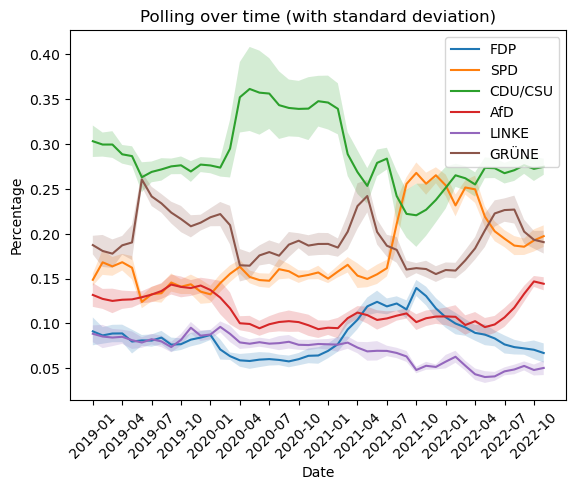

In [14]:
idxs = groups.index.map(lambda x: x.strftime("%Y-%m"))

for party in parties:
    plt.fill_between(
        idxs,
        groups["avg_" + party] - groups["std_" + party],
        groups["avg_" + party] + groups["std_" + party],
        alpha=0.2,
    )
    plt.plot(idxs, groups["avg_" + party], label=party)

plt.xticks(range(0, len(idxs), 3), idxs[::3], rotation=45)
plt.title("Polling over time (with standard deviation)")
plt.xlabel("Date")
plt.ylabel("Percentage")
plt.legend()
plt.show()

# PolitPro

As Europe Elects only collects polling data for countries in Europe, we cannot obtain polling data for Japan or South Korea from them.

PolitPro, another poll aggregator, does collect polling data for Japan. This data is not collected as regularly as with other European countries. As a result, the time series of the polling data is not as useful. However, we demonstrate that we are still able to use this data in case we need it.

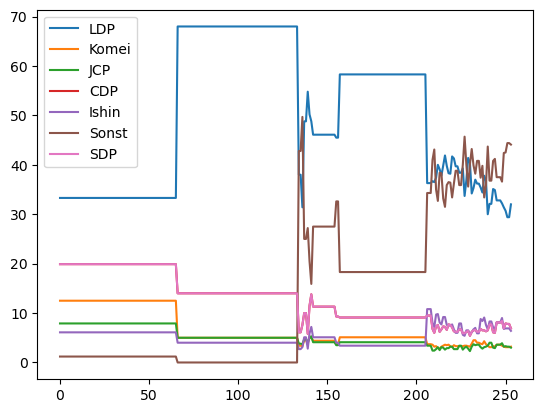

In [ ]:
data = np.genfromtxt(
    "./data/countries/Japan/JapanWithoutDateReverse.csv", delimiter=",", names=True
)

plt.figure()
for col in data.dtype.names:
    plt.plot(data[col], label=col)
plt.legend()
plt.show()